# This Notebook has demo code for Interactive Segmentation

In [ ]:
#importing library
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import glob
from matplotlib import cm

# Libraries
from PIL import Image as I
from sklearn.metrics.pairwise import cosine_similarity as cs
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from PIL import ImageOps, ImageDraw
from scipy.io import loadmat


import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
import os
from PIL import ImageFile
from pathlib import Path

### Function to display image

In [21]:
# function -> Display_image, compare_image,draw_boxes
def display_image(img,title='Image',fig_size =(15, 9),colour_cvt=True):
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    
    res = isinstance(img,str)
    if res:
        img = cv2.imread(img)
#     if len(img1.shape)==3:    
    if colour_cvt:
        img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
        

        
def compare_image(img1, img2,fig_size =(15, 9),colour_cvt=True):
    #fig,(ax1,ax2) = plt.subplots(1,2)
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    
    res = isinstance(img1, str)
    if res:
        img1= cv2.imread(img1)
    res =isinstance(img2,str)
    if res:
        img2= cv2.imread(img2)
    
    ax1 =fig.add_subplot(1,2,1)
#     if len(img1.shape)==3:
    if colour_cvt:
        img1= cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
        plt.imshow(img1)
    else:
        plt.imshow(img1, cmap='gray')
    ax1.set_title("original")
    ax1.axis('off')
       
    ax2 =fig.add_subplot(1,2,2)
#     if len(img1.shape)==3:
    if colour_cvt:
        img2= cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
        plt.imshow(img2)
    else:
        plt.imshow(img2,cmap='gray')
    ax2.set_title("result")
    ax2.axis('off')
   
  
def draw_boxes(imgs, boxes,title='bounding box'):
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(imgs, (x1, y1), (x2, y2), (0,255,0), 3)
    return imgs

### Setting the path of the image

In [ ]:
# path declaration
path = 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/interactivesegmentation/images/images/*.jpg'
img_path_list = glob.glob(path)
print('No of image in directory : ',len(img_path_list))
img_path=img_path_list[0]

# manual seting path
# img_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Input Image.jpeg"

# step 1. Bounding Box Detection

In [2]:
#path
path ='C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/'

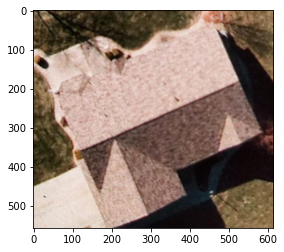

In [3]:
# Target Image

# Hummer annotation

# ann = {"x":542,"y":362,"width":395,"height":369}
ann ={"x":242,"y":367,"width":615,"height":557}

# Read from annotation (Broken door)
# ti = qi_hummer[ann['y']:ann['y']+ann['height'], ann['x']:ann['x']+ann['width']]

qi_hummer = np.array(I.open(path+'Input Image.jpeg'))
ti = qi_hummer[ann['y']:ann['y']+ann['height'], ann['x']:ann['x']+ann['width']]
# ti_back = qi8_back[80:170, 55:200]
# plt.imsave(path+'ti_back.jpg', ti_back)
# Save the target image (broken door)
plt.imsave(path+'ti.jpg', ti)

# Show the target image
plt.imshow(ti)

In [4]:
def draw_rect(qi3, w, h, w2, h2):
    img2 = Image.fromarray(qi3)
    draw = ImageDraw.Draw(img2)
    draw.rectangle(((w, h), (w+w2, h+h2)), outline='Yellow', width=5)
    plt.imshow(np.array(img2))

In [5]:
def scale(ti, qi, bi_shape):
    h, w, _ = np.array(Image.open(qi)).shape
    h2, w2, _ = bi_shape
    h1, w1, _ = np.array(Image.open(ti)).shape
    return np.array(Image.open(ti).resize((int(w1*w/w2), int(h1*h/h2))))

In [6]:
# C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/checkpoints\resnet18-5c106cde.pth
os.environ['TORCH_HOME'] = 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/'

In [7]:
# Define & Download the pretrained model

model = models.resnet18(pretrained=True)

# local model loading 
# model_path ="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
# model = models.resnet18()
# model.load_state_dict(torch.load(model_path))


# Specify the layer embedding 
layer = model._modules.get('avgpool')

model.eval()

# convert into tensors
to_tensor = transforms.ToTensor()


In [9]:
# Function to get the embedding of the images

def get_vector(img):
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(to_tensor(img).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(torch.flatten(o.data, 1).squeeze())
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [10]:
# Function for Image embedding search

def slid_ims(qi,ti):
    h,w,_ = ti.shape
    ti_emb = get_vector(ti).reshape(1,-1)
    sl = [(cs(get_vector(qi[i:i+h, j:j+w]).reshape(1,-1), ti_emb),i,j)  for i in range(0,qi.shape[0]-h,10) for j in range(0,qi.shape[1]-w,10)]
    tl = [x[0] for x in sl]
    ma = np.argmax(tl)
    return sl[ma]

In [11]:
def slid_ensemble(qi, ti):
    h, w, _ = ti.shape
    s = np.linalg.svd(ti.transpose(2, 0, 1))[1].reshape(1, -1)
    sl1 = [(cs(np.linalg.svd(qi[i:i+h, j:j+w].transpose(2, 0, 1))[1].reshape(1, -1), s), i, j)
           for i in range(0, qi.shape[0]-h, 50) for j in range(0, qi.shape[1]-w, 50)]
    ti_emb = get_vector(ti).reshape(1, -1)
    sl2 = [(cs(get_vector(qi[i:i+h, j:j+w]).reshape(1, -1), ti_emb), i, j)
           for i in range(0, qi.shape[0]-h, 50) for j in range(0, qi.shape[1]-w, 50)]
    sl = [((x[0]+y[0])/2, x[1], x[2]) for x, y in zip(sl1, sl2)]
    tl = [x[0] for x in sl]
    ma = np.argmax(tl)
    return sl[ma]

In [12]:
def em(qi, h, w, tis, eps=10):
    l, b, _ = tis
    mh, mw, _ = qi.shape
    ph, pw = int(mh*.05), int(mw*.05)
    m = np.mean(qi[h:h+l, w:w+b])
    x1 = w
    x2 = w+b
    y1 = h
    y2 = h+l
    while x1 > pw:
        nw = x1-pw
        if (np.mean(qi[h:h + l, nw:w])-m) > eps:
            break
        x1 = nw
    while y1 > ph:
        nh = y1-ph
        if (np.mean(qi[nh:h, w:w+b])-m) > eps:
            break
        y1 = nh
    while x2+pw < mw-pw:
        nw = x2+pw
        if np.mean(qi[h:h + l, w:x2])-m > eps:
            break
        x2 = nw

    while y2+ph < mh-ph:
        nh = y2+ph
        if np.mean(qi[h+l:nh, w:w+b]) - m > eps:
            break
        y2 = nh

    return x1, y1, x2, y2

91.0 %


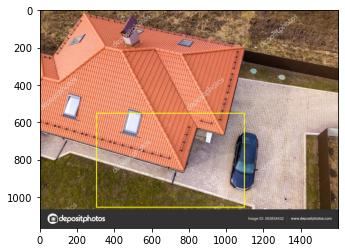

In [14]:
# qi4 = qi9_back
# qi4=qi_hummer
qi4= np.array(I.open(path+'image_17_top.jpg'))
ti4 = scale(path+'ti.jpg', path+'image_17_top.jpg',  np.array(Image.open(path+'Input Image.jpeg')).shape)
sim, h4, w4 = slid_ensemble(qi4, ti4)
print(round(sim[0][0]*100), '%')
draw_rect(qi4, w4,h4,ti4.shape[1], ti4.shape[0])

In [18]:
x1,y1,x2,y2 = em(qi4, h4,w4, ti4.shape,eps=35)
bbox=(x1,y1,x2,y2)

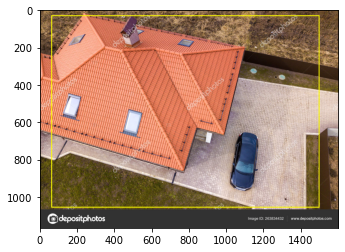

In [20]:
draw_rect(qi4, x1,y1,x2-x1,y2-y1)

# Step 2. Extract the Foreground Object 

### Foreground Extraction Funciton

In [21]:
# Extract_forground -> function  Input image or image path
def Extract_forground(img,bbox):
    res = isinstance(img,str)
    if res:
        img= cv2.imread(img)
    # create a simple mask image similar 
    # to the loaded image, with the  
    # shape and return type 
    mask = np.zeros(img.shape[:2], np.uint8) 

    # specify the background and foreground model 
    # using numpy the array is constructed of 1 row 
    # and 65 columns, and all array elements are 0 
    # Data type for the array is np.float64 (default) 
    backgroundModel = np.zeros((1, 65), np.float64) 
    foregroundModel = np.zeros((1, 65), np.float64) 

    # define the Region of Interest (ROI) 
    # as the coordinates of the rectangle 
    # where the values are entered as 
    # (startingPoint_x, startingPoint_y, width, height) 
    # these coordinates are according to the input image 
    # it may vary for different images 
    # rectangle = (30, 20, 200, 400)
    # rectangle =(186, 34, 303, 304)
#     rectangle =(242,367,615,557)
    rectangle=bbox

    # apply the grabcut algorithm with appropriate 
    # values as parameters, number of iterations = 3  
    # cv2.GC_INIT_WITH_RECT is used because 
    # of the rectangle mode is used  
    cv2.grabCut(img, mask, rectangle,   
                backgroundModel, foregroundModel, 
                3, cv2.GC_INIT_WITH_RECT) 

    # In the new mask image, pixels will  
    # be marked with four flags  
    # four flags denote the background / foreground  
    # mask is changed, all the 0 and 2 pixels  
    # are converted to the background 
    # mask is changed, all the 1 and 3 pixels 
    # are now the part of the foreground 
    # the return type is also mentioned, 
    # this gives us the final mask 
    mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 

    # The final mask is multiplied with  
    # the input image to give the segmented image. 
    img = img * mask2[:, :, np.newaxis] 
    
    return img

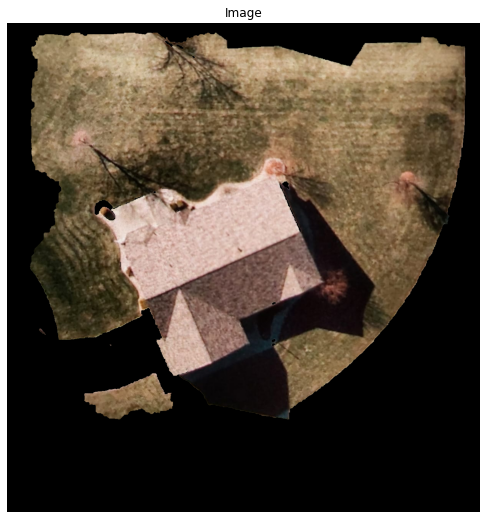

In [24]:
# display extracted image
img = Extract_forground(path+'Input Image.jpeg',bbox)
display_image(img)

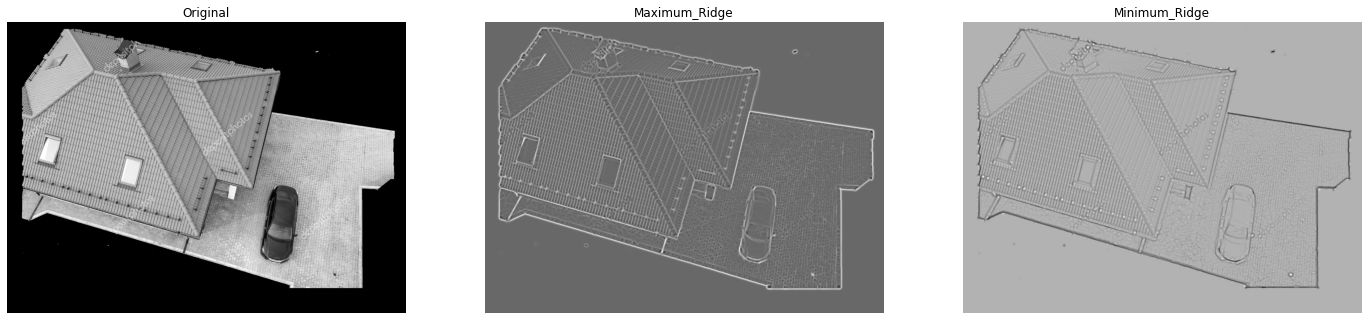

In [80]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

# src_path = 'Fundus_photograph_of_normal_left_eye.jpg'
# src_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/Input_Image.jpg"
src_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/house_with_car.jpg"
save_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/"
file_name=src_path.split('/')[-1]
def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
#     display_image(maxima_ridges,colour_cvt=False)
#     display_image(minima_ridges,colour_cvt=False)
    return maxima_ridges, minima_ridges

def plot_images(*images):
#     fig = plt.figure()
#     fig = plt.gcf()
#     fig.set_size_inches(fig_size)
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True,figsize=(20,15))
    title_list=['Original','Maximum_Ridge','Minimum_Ridge']
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(title_list[i])
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.savefig(save_path+'ridge_'+file_name, bbox_inches="tight")
    plt.show()

img = cv2.imread(src_path, 0) # 0 imports a grayscale
# img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
if img is None:
    raise(ValueError(f"Image didn/'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img, sigma=3.0)

plot_images(img, a, b)

In [84]:
def detect_ridges(img_path, SAVE_PATH, sigma=1.0):
    gray = cv2.imread(img_path,0)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

#     file_name = img_path.split('/')[-1]
#     file_name = file_name.split('.')[0]
#     max_ridges_path=SAVE_PATH+file_name+'_maxima_ridges.jpg'
#     min_ridges_path = SAVE_PATH + file_name + '_minima_ridges.jpg'
#     print(type(maxima_ridges))
#     print(maxima_ridges.shape)
#     display_image(maxima_ridges,colour_cvt=False)
#     display_image(minima_ridges,colour_cvt=False)
#     print(max_ridges_path)
#     print(min_ridges_path)
#     cv2.imwrite(max_ridges_path, maxima_ridges)
#     cv2.imwrite(min_ridges_path, minima_ridges)



In [85]:
def save_ridge_img(img,save_path,fig_size=(40,30)):
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(save_path)
    plt.close(fig)

In [93]:
SAVE_PATH="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/"
# src_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/Input_Image.jpg"
src_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/house_with_car.jpg"

file_name=src_path.split('/')[-1]

maxima_ridges, minima_ridges =detect_ridges(src_path,SAVE_PATH,4.0)

file_name = file_name.split('.')[0]
print(file_name)
max_ridges_path=SAVE_PATH+file_name+'_maxima_ridges.jpg'
min_ridges_path = SAVE_PATH + file_name + '_minima_ridges.jpg'
print(max_ridges_path)
print(min_ridges_path)

save_ridge_img(maxima_ridges,max_ridges_path)
save_ridge_img(minima_ridges,min_ridges_path)

house_with_car
C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/house_with_car_maxima_ridges.jpg
C:/Users/Sanjeev/Documents/Accenture office/segmentation/Interact_seg_data/house_with_car_minima_ridges.jpg


In [54]:
d=255*maxima_ridges
dd=SAVE_PATH+'dd'+'_maxima_ridges.jpg'
cv2.imwrite(dd, d)

True

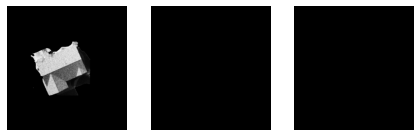

In [42]:
img = cv2.imread(src_img, 0)
a=  cv2.imread(SAVE_PATH+'Input_Image'+'_maxima_ridges.jpg')
b= cv2.imread(SAVE_PATH + 'Input_Image' + '_minima_ridges.jpg')
plot_images(img,a,b)

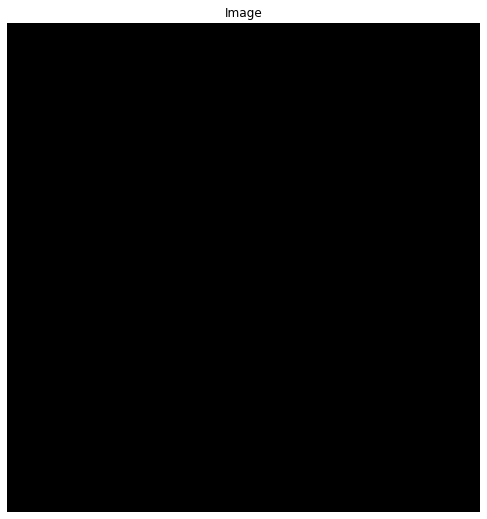

In [31]:
display_image(a, colour_cvt=False)

# Step 3. Watershed Alogorithm / Interactive segmentation

## Helping Function Declaration

In [ ]:
#creating function for select color
def create_color(no_of_color=10):
    colors = []
    # One color for each single digit
    for i in range(no_of_color):
        x = np.array(cm.tab10(i))[:3]*255
        colors.append(x)
        
    return colors

In [ ]:
# mouse event 
def mouse_callback(event, x, y,flags, param):
    
    global marks_updated 

    if event == cv2.EVENT_LBUTTONDOWN:
        
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 5,(current_marker) , -1)
        
        # DISPLAY ON USER IMAGE
        cv2.circle(img_copy, (x, y), 5,colors[current_marker] , -1)
        marks_updated = True


In [ ]:
#chane if you wan
# path = "C:/Users/Sanjeev/Documents/Accenture office/segmentation/DATA/Input_Image.jpg"
width = 800 
height = 600
# Default settings
current_marker = 1
marks_updated = False
n_markers = 10
colors=create_color()

In [ ]:
cv2.namedWindow('Image')
cv2.setMouseCallback('Image',mouse_callback)

img = cv2.imread(img_path)
img = cv2.resize(img,(width,height))
img_copy = img.copy()
img_seg_boundry = img.copy()
segments = np.zeros(img_copy.shape,dtype=np.uint8)
marker_image = np.zeros(img_copy.shape[:2],dtype=np.int32)

while True:
    cv2.imshow('Image',img_copy)
    cv2.imshow('segmented_boundries',img_seg_boundry)
    cv2.imshow('Segments', segments)



    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break

    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        img_copy = img.copy()
        marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
        segments = np.zeros(img.shape,dtype=np.uint8)
        img_seg_boundry = img.copy()

    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit

        current_marker  = int(chr(k))


    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:

        marker_image_copy = marker_image.copy()
        cv2.watershed(img, marker_image_copy)

        segments = np.zeros(img.shape,dtype=np.uint8)

        contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # For every entry in contours
        for i in range(len(contours)):

            # last column in the array is -1 if an external contour (no contours inside of it)
            if hierarchy[0][i][3] == -1:

                # We can now draw the external contours from the list of contours
                cv2.drawContours(img_seg_boundry, contours, i, (0,0,255), 1)


        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]



            marks_updated = False

cv2.destroyAllWindows()

# This Notebook has demo code for Interactive Segmentation

In [7]:
#importing library
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import glob
from matplotlib import cm

### Function to display image

In [8]:
def display_image(img,title='Image',fig_size =(15, 9),colour_cvt=True):
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    
    res = isinstance(img,str)
    if res:
        img = cv2.imread(img)
#     if len(img1.shape)==3:    
    if colour_cvt:
        img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
        

        
def compare_image(img1, img2,fig_size =(15, 9),colour_cvt=True):
    #fig,(ax1,ax2) = plt.subplots(1,2)
    fig = plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(fig_size)
    
    res = isinstance(img1, str)
    if res:
        img1= cv2.imread(img1)
    res =isinstance(img2,str)
    if res:
        img2= cv2.imread(img2)
    
    ax1 =fig.add_subplot(1,2,1)
#     if len(img1.shape)==3:
    if colour_cvt:
        img1= cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
        plt.imshow(img1)
    else:
        plt.imshow(img1, cmap='gray')
    ax1.set_title("original")
    ax1.axis('off')
       
    ax2 =fig.add_subplot(1,2,2)
#     if len(img1.shape)==3:
    if colour_cvt:
        img2= cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
        plt.imshow(img2)
    else:
        plt.imshow(img2,cmap='gray')
    ax2.set_title("result")
    ax2.axis('off')
   
  
def draw_boxes(imgs, boxes,title='bounding box'):
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(imgs, (x1, y1), (x2, y2), (0,255,0), 3)
    return imgs

### Setting the path of the image

In [9]:
# path declaration
path = 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/interactivesegmentation/images/images/*.jpg'
img_path_list = glob.glob(path)
print('No of image in directory : ',len(img_path_list))
img_path=img_path_list[0]

# manual seting path
# img_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Input Image.jpeg"

No of image in directory :  137


# step 1. Bounding Box Detection

### Bounding box class for handling the mouse event 

In [10]:
# bounding  box class 
class BoundingBox():
    def __init__(self,img_path):
        self.img_path=img_path
        self.original_img = cv2.imread(self.img_path)
        self.clone_img = self.original_img.copy()

        # Bounding box reference points
        self.bbox = []
#         ix, iy = -1, -1

    def draw_bounding_event(self,event, x, y, flags, param):
        global ix, iy, drawing, overlay, output, alpha  
        overlay = self.original_img.copy()
        output = self.original_img.copy()
        alpha = 0.5

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix, iy = x, y
            self.bbox.append((x, y))
            
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing == True:
               
                cv2.rectangle(overlay, (ix, iy), (x, y), (0, 255, 0), -1)
                cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, self.clone_img)
                cv2.imshow('Bounding Box Canvas', self.clone_img)
                

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            cv2.rectangle(overlay, (ix, iy), (x, y), (0, 255, 0), -1)
            cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, self.original_img)
#             print('rect : ',(ix, iy), (x, y))
            self.bbox.append((x, y))
            
                
        # Clear drawing boxes on right mouse button click
        elif event == cv2.EVENT_RBUTTONDOWN:
            self.original_img=cv2.imread(self.img_path)
            self.clone_img = self.original_img.copy()
#             self.clone_img=cv2.imread(self.img_path)
            self.bbox=[]  #empty the bbox poing
            overlay = self.original_img.copy()
            output = self.original_img.copy()
            
def get_rectangle(bbox):
    start_pt, end_pt= bbox
    return (start_pt[0],start_pt[1],end_pt[0],end_pt[1])

### Function to interect with image and return bounding box

In [11]:
# get_bounding_box() -> function, input path        
def get_bounding_box(img_path):
#     ix, iy, drawing =-1,-1, False
    box =BoundingBox(img_path)
    #make cv2 windows, set mouse callback
    cv2.namedWindow('Bounding Box Canvas')
    cv2.setMouseCallback('Bounding Box Canvas', box.draw_bounding_event)
    while(True):
        cv2.imshow('Bounding Box Canvas', box.clone_img)

        # This is where we get the keyboard input
        # Then check if it's "m" (if so, toggle the drawing mode)
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.waitKey(1) & 0xFF == 27:
            break
    cv2.destroyAllWindows()
    return get_rectangle(box.bbox)

### Get object bounding box 

In [12]:
# ix, iy, drawing =-1,-1, False
# bbox=get_bounding_box(img_path)
# print(bbox)

(188, 35, 309, 305)


# Step 2. Extract the Foreground Object 

### Foreground Extraction Funciton

In [13]:
# Extract_forground -> function  Input image or image path
def Extract_forground(img,bbox):
    res = isinstance(img,str)
    if res:
        img= cv2.imread(img)
    # create a simple mask image similar 
    # to the loaded image, with the  
    # shape and return type 
    mask = np.zeros(img.shape[:2], np.uint8) 

    # specify the background and foreground model 
    # using numpy the array is constructed of 1 row 
    # and 65 columns, and all array elements are 0 
    # Data type for the array is np.float64 (default) 
    backgroundModel = np.zeros((1, 65), np.float64) 
    foregroundModel = np.zeros((1, 65), np.float64) 

    # define the Region of Interest (ROI) 
    # as the coordinates of the rectangle 
    # where the values are entered as 
    # (startingPoint_x, startingPoint_y, width, height) 
    # these coordinates are according to the input image 
    # it may vary for different images 
    # rectangle = (30, 20, 200, 400)
    # rectangle =(186, 34, 303, 304)
#     rectangle =(242,367,615,557)
    rectangle=bbox

    # apply the grabcut algorithm with appropriate 
    # values as parameters, number of iterations = 3  
    # cv2.GC_INIT_WITH_RECT is used because 
    # of the rectangle mode is used  
    cv2.grabCut(img, mask, rectangle,   
                backgroundModel, foregroundModel, 
                3, cv2.GC_INIT_WITH_RECT) 

    # In the new mask image, pixels will  
    # be marked with four flags  
    # four flags denote the background / foreground  
    # mask is changed, all the 0 and 2 pixels  
    # are converted to the background 
    # mask is changed, all the 1 and 3 pixels 
    # are now the part of the foreground 
    # the return type is also mentioned, 
    # this gives us the final mask 
    mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 

    # The final mask is multiplied with  
    # the input image to give the segmented image. 
    img = img * mask2[:, :, np.newaxis] 
    
    return img

In [14]:
# # display extracted image
# img = Extract_forground(img_path,bbox)
# # display_image(img)

# Step 3. Watershed Alogorithm / Interactive segmentation

## Helping Function Declaration

In [15]:
#creating function for select color
def create_color(no_of_color=10):
    colors = []
    # One color for each single digit
    for i in range(no_of_color):
        x = np.array(cm.tab10(i))[:3]*255
        colors.append(x)
        
    return colors

In [16]:
# mouse event 
def mouse_callback(event, x, y,flags, param):
    
    global marks_updated 

    if event == cv2.EVENT_LBUTTONDOWN:
        
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 5,(current_marker) , -1)
        
        # DISPLAY ON USER IMAGE
        cv2.circle(img_copy, (x, y), 5,colors[current_marker] , -1)
        marks_updated = True

In [17]:
#chane if you wan
# path = "C:/Users/Sanjeev/Documents/Accenture office/segmentation/DATA/Input_Image.jpg"
width = 800 
height = 600

# Default settings
current_marker = 1
marks_updated = False
n_markers = 10
colors=create_color()

In [18]:
cv2.namedWindow('Image')
cv2.setMouseCallback('Image',mouse_callback)

# img = cv2.imread(img_path)
img = cv2.resize(img,(width,height))
img_copy = img.copy()
img_seg_boundry = img.copy()
segments = np.zeros(img_copy.shape,dtype=np.uint8)
marker_image = np.zeros(img_copy.shape[:2],dtype=np.int32)

while True:
    cv2.imshow('Image',img_copy)
    cv2.imshow('segmented_boundries',img_seg_boundry)
    cv2.imshow('Segments', segments)



    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break

    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        img_copy = img.copy()
        marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
        segments = np.zeros(img.shape,dtype=np.uint8)
        img_seg_boundry = img.copy()

    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit

        current_marker  = int(chr(k))


    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:

        marker_image_copy = marker_image.copy()
        cv2.watershed(img, marker_image_copy)

        segments = np.zeros(img.shape,dtype=np.uint8)

        contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # For every entry in contours
        for i in range(len(contours)):

            # last column in the array is -1 if an external contour (no contours inside of it)
            if hierarchy[0][i][3] == -1:

                # We can now draw the external contours from the list of contours
                cv2.drawContours(img_seg_boundry, contours, i, (0,0,255), 1)


        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]



            marks_updated = False

cv2.destroyAllWindows()

In [ ]:
# path declaration
path = 'C:/Users/Sanjeev/Documents/Accenture office/segmentation/interactivesegmentation/images/images/*.jpg'
img_path_list = glob.glob(path)
print('No of image in directory : ',len(img_path_list))
img_path=img_path_list[20]
print(img_path)
# manual seting path
# img_path="C:/Users/Sanjeev/Documents/Accenture office/segmentation/Input Image.jpeg"

# Final interactive demo

In [19]:
ix, iy, drawing =-1,-1, False
bbox=get_bounding_box(img_path)
# print(bbox)

# display extracted image
img = Extract_forground(img_path,bbox)
# display_image(img)

#chane if you wan
# path = "C:/Users/Sanjeev/Documents/Accenture office/segmentation/DATA/Input_Image.jpg"
width = 800 
height = 600

# Default settings
current_marker = 1
marks_updated = False
n_markers = 10
colors=create_color()

cv2.namedWindow('Image')
cv2.setMouseCallback('Image',mouse_callback)

# img = cv2.imread(img_path)
img = cv2.resize(img,(width,height))
img_copy = img.copy()
img_seg_boundry = img.copy()
segments = np.zeros(img_copy.shape,dtype=np.uint8)
marker_image = np.zeros(img_copy.shape[:2],dtype=np.int32)

while True:
    cv2.imshow('Image',img_copy)
#     cv2.imshow('segmented_boundries',img_seg_boundry)
    cv2.imshow('Segments', segments)



    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break

    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        img_copy = img.copy()
        marker_image = np.zeros(img.shape[0:2], dtype=np.int32)
        segments = np.zeros(img.shape,dtype=np.uint8)
        img_seg_boundry = img.copy()

    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit

        current_marker  = int(chr(k))


    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:

        marker_image_copy = marker_image.copy()
        cv2.watershed(img, marker_image_copy)

        segments = np.zeros(img.shape,dtype=np.uint8)

        contours, hierarchy = cv2.findContours(marker_image_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # For every entry in contours
        for i in range(len(contours)):

            # last column in the array is -1 if an external contour (no contours inside of it)
            if hierarchy[0][i][3] == -1:

                # We can now draw the external contours from the list of contours
                cv2.drawContours(img_seg_boundry, contours, i, (0,0,255), 1)


        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]



            marks_updated = False

cv2.destroyAllWindows()